# This Titanic notebook will be the first time I solve kaggle by myselfe (kind of).
### This will be an attempt to improve https://www.kaggle.com/startupsci/titanic-data-science-solutions/notebook / do it in my own words.

## Abstract:
I will  solve the titanic challange from the Kaggle website.<br>
This solution is based on a tutorial https://www.kaggle.com/startupsci/titanic-data-science-solutions/notebook, however it has two main differrences which eventually gave a higher score:<br>
> - "Deck" feature: This is the main cause of improvement
> - "CabinBand" feature: This might be a minor cause in improvement

### The "Deck" feature
In the tutorial, the author decided to ignore the "Cabin" feature, when I saw the cabin feature I noticed a pattern which might indicate the location of the rooms on the ship.<br>
In order to investigate this I found a website with the titanics deckplans: https://www.encyclopedia-titanica.org/titanic-deckplans/ <br>
In the deckplans you can see that there are more decks than classes, which might mean that the only reason that classes is a major player here is because it is located in higher decks. This further means that there are classes which the survival rate within the class changes according to the deck.<br>
Luckily, the cabin number contains the deck as a prefixed letter to the cabin number, therefore I created a new feature out of this letter called "Deck". We will later see in the decision tree visualization that this feature played a major role in the classification.

### The "CabinBand" Feature
If you look at the deck plans, another feature you can derive from the cabin number is the approximate location on the plane of the deck.<br>
unfortunately, when checking if there was any correlation between the different ends of the ship to the survivavl rate, I found no good correlation.
However, when checking correlation between the different sides of the ship, I found a better correlation.<br>
I decided to use this feature. It played a smaller role than the deck as you can imagine.

## Load the data

In [1425]:
import pandas as pd

test_df = pd.read_csv('test.csv')
train_df = pd.read_csv('train.csv')
combine_df = [train_df, test_df]
train_df.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


In [1426]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [1427]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


we will not need PassengereId

In [1428]:
for dataset in combine_df:
    dataset.drop(["PassengerId"], axis=1, inplace=True)

## Handle Sex:

In [1429]:
for dataset in combine_df:
    dataset.Sex.fillna(-1, inplace=True)
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)

train_df.head(10) 

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,C123,S
4,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,NaN,S
5,0,3,"Moran, Mr. James",1,NaN,0,0,330877,8.4583,NaN,Q
6,0,1,"McCarthy, Mr. Timothy J",1,54.0,0,0,17463,51.8625,E46,S
7,0,3,"Palsson, Master. Gosta Leonard",1,2.0,3,1,349909,21.0750,NaN,S
8,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",0,27.0,0,2,347742,11.1333,NaN,S
9,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",0,14.0,1,0,237736,30.0708,NaN,C


## handle the Cabin feature

### convert Cabin into Cabin Number -> Cabin  Band

In [1431]:
for dataset in  combine_df:
    dataset['CabinNumber'] = dataset.Cabin.str.extract('[A-G](\d+)', expand=False)
    dataset.CabinNumber.fillna(0, inplace=True)
    dataset['CabinNumber'] = dataset['CabinNumber'].astype(int)
combine_df = [train_df, test_df]
train_df.CabinNumber.unique()

array([  0,  85, 123,  46,   6, 103,  56,  23,  78,  33,  30,  52,  28,
        83,  73,  31,   5,  10,  26, 110,  58, 101,  69,  47,  86,   2,
        19,   7,  49,   4,  32,  80,  36,  15,  93,  35,  87,  77,  67,
        94, 125,  99, 118,  22, 106,  65,  54,  57,  34,  18, 124,  91,
        40, 128,  37,  50,  82,  96,  44, 104, 111,  92,  38,  21,  12,
        63,  14,  20,  79,  25,  95,  39,  70,  16,  68,  41,   9,  48,
       126,  71,  51,  62,  24,  90,  45,   8, 121,  11,   3,  17, 102,
        42, 148], dtype=int64)

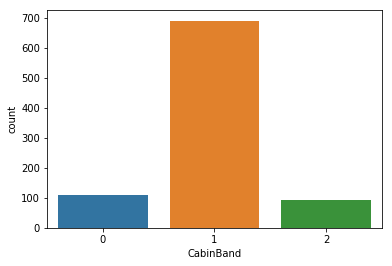

In [1432]:
import seaborn as sns
for dataset in combine_df:
    dataset['CabinBand'] = 0
    dataset.loc[dataset['CabinNumber'] == 0, 'CabinBand'] = 1
    dataset.loc[dataset['CabinNumber'] % 2 == 1, 'CabinBand'] = 2
    #dataset['CabinBand'] = pd.cut(dataset['CabinNumber'], 3, labels=['front', 'middle', 'back'])
    dataset.drop(['CabinNumber'],  axis=1, inplace=True)
#combine_df = [train_df, test_df]
sns.countplot(train_df['CabinBand'])

In [1433]:
train_df[['CabinBand', 'Survived']].groupby(['CabinBand'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,CabinBand,Survived
2,2,0.739130
0,0,0.611111
1,1,0.301013


### create the Deck feature

In [1434]:
for dataset in combine_df:
    dataset['Deck'] = dataset.Cabin.str.extract('([A-G])\d+', expand=False)
combine_df = [train_df, test_df]
train_df.Deck.unique()

array([nan, 'C', 'E', 'G', 'D', 'A', 'B', 'F'], dtype=object)

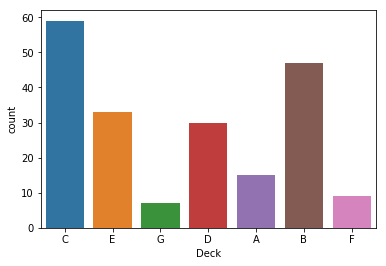

In [1435]:
sns.countplot(train_df['Deck'])

In [1436]:
train_df[['Deck', 'Survived']].groupby(['Deck'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Deck,Survived
5,F,0.777778
3,D,0.766667
4,E,0.757576
1,B,0.744681
2,C,0.593220
0,A,0.466667
6,G,0.285714


C:\Anaconda3\envs\deeplearning\lib\site-packages\seaborn\axisgrid.py:703: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
C:\Anaconda3\envs\deeplearning\lib\site-packages\seaborn\axisgrid.py:708: UserWarning: Using the pointplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


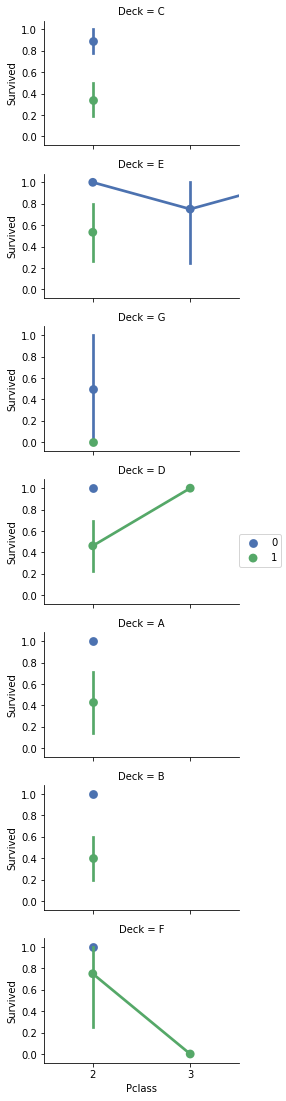

In [1437]:
grid = sns.FacetGrid(train_df, row='Deck', size=2.2, aspect=1.6)
grid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette='deep')
grid.add_legend()

In [1438]:
deckMapping = {'G':1, 'A':2, 'C':3, 'B':4, 'E':5, 'D':6, 'F':7}
for dataset in combine_df:
    dataset['Deck'] = dataset['Deck'].map(deckMapping)
    dataset.Deck.fillna(-1, inplace=True)
    dataset['Deck'] = dataset['Deck'].astype(int)

In [1439]:
Survived = train_df['Survived']
deckCor = Survived.corr(train_df['Deck'])
deckCor

0.3327165801431221

In [1440]:
deckCor = Survived.corr(train_df['Deck'], "kendall")
deckCor

0.31378654354551616

In [1441]:
deckCor = Survived.corr(train_df['Deck'], 'spearman')
deckCor

0.3280672865268721

In [1442]:
train_df = train_df.drop(['Cabin'], axis=1)
test_df = test_df.drop(['Cabin'], axis=1)
combine_df = [train_df, test_df]
train_df.head(10)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,CabinBand,Deck
0,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,S,1,-1
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C,2,3
2,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,S,1,-1
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,S,2,3
4,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,S,1,-1
5,0,3,"Moran, Mr. James",1,NaN,0,0,330877,8.4583,Q,1,-1
6,0,1,"McCarthy, Mr. Timothy J",1,54.0,0,0,17463,51.8625,S,0,5
7,0,3,"Palsson, Master. Gosta Leonard",1,2.0,3,1,349909,21.0750,S,1,-1
8,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",0,27.0,0,2,347742,11.1333,S,1,-1
9,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",0,14.0,1,0,237736,30.0708,C,1,-1


## Handle the Age feature

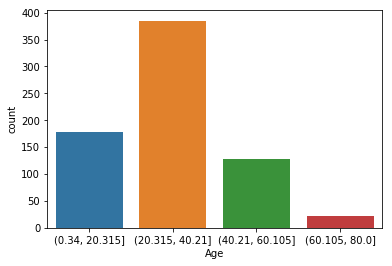

In [1443]:
age_band = pd.cut(train_df['Age'], 4)
#train_df['AgeBand'] = pd.cut(train_df['Age'], 4)
sns.countplot(age_band)

### I disregaurded the method used in the turorial because it lowered the score

In [1444]:
for dataset in combine_df:
    dataset['Age'].fillna(-1, inplace=True)
    dataset['Age'] = dataset['Age'].astype(int)
#import numpy as np
#guess_ages = np.zeros((2,3))
#for dataset in combine_df:
#    for i in range(0,2):
#        for j in range(0,3):
#            non_null_age_collection_by_class_gender = dataset[(dataset['Sex']==i)& \
#                                                              (dataset['Pclass']==j+1)]['Age'].dropna() 
#            age_guess = non_null_age_collection_by_class_gender.median()
#            guess_ages[i,j] = int(age_guess/0.5 +  0.5) * 0.5
#    print(guess_ages)
#    for i in range(0,2):
#        for j in range(0,3):
#            dataset.loc[(dataset.Age.isnull()) & (dataset.Sex == i) \
#                        & (dataset.Pclass == j+1), 'Age'] = guess_ages[i,j]
#    dataset['Age'] = dataset['Age'].astype(int)
            
train_df.head(10)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,CabinBand,Deck
0,0,3,"Braund, Mr. Owen Harris",1,22,1,0,A/5 21171,7.2500,S,1,-1
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38,1,0,PC 17599,71.2833,C,2,3
2,1,3,"Heikkinen, Miss. Laina",0,26,0,0,STON/O2. 3101282,7.9250,S,1,-1
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35,1,0,113803,53.1000,S,2,3
4,0,3,"Allen, Mr. William Henry",1,35,0,0,373450,8.0500,S,1,-1
5,0,3,"Moran, Mr. James",1,-1,0,0,330877,8.4583,Q,1,-1
6,0,1,"McCarthy, Mr. Timothy J",1,54,0,0,17463,51.8625,S,0,5
7,0,3,"Palsson, Master. Gosta Leonard",1,2,3,1,349909,21.0750,S,1,-1
8,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",0,27,0,2,347742,11.1333,S,1,-1
9,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",0,14,1,0,237736,30.0708,C,1,-1


In [1445]:
for dataset in combine_df:
    dataset.loc[ dataset['Age'] == -1, 'Age'] = -1
    dataset.loc[ (dataset['Age'] > -1) & (dataset['Age'] <= 20), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 20) & (dataset['Age'] <= 40), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 40) & (dataset['Age'] <= 60), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 60, 'Age'] = 4
train_df.head(10)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,CabinBand,Deck
0,0,3,"Braund, Mr. Owen Harris",1,2,1,0,A/5 21171,7.2500,S,1,-1
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,0,PC 17599,71.2833,C,2,3
2,1,3,"Heikkinen, Miss. Laina",0,2,0,0,STON/O2. 3101282,7.9250,S,1,-1
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,2,1,0,113803,53.1000,S,2,3
4,0,3,"Allen, Mr. William Henry",1,2,0,0,373450,8.0500,S,1,-1
5,0,3,"Moran, Mr. James",1,-1,0,0,330877,8.4583,Q,1,-1
6,0,1,"McCarthy, Mr. Timothy J",1,3,0,0,17463,51.8625,S,0,5
7,0,3,"Palsson, Master. Gosta Leonard",1,1,3,1,349909,21.0750,S,1,-1
8,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",0,2,0,2,347742,11.1333,S,1,-1
9,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",0,1,1,0,237736,30.0708,C,1,-1


## Creating Title feature

In [1446]:
for dataset in combine_df:
    dataset['Title'] = dataset['Name'].str.extract(r'(\w+)\.')
train_df['Title'].value_counts()

C:\Anaconda3\envs\deeplearning\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  


Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Col           2
Major         2
Mlle          2
Jonkheer      1
Lady          1
Sir           1
Mme           1
Countess      1
Capt          1
Don           1
Ms            1
Name: Title, dtype: int64

In [1447]:
for dataset in combine_df:    
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    dataset['Title'] = dataset['Title'].replace(['Rev', 'Dr', 'Countess', 'Jonkheer', 'Don', 'Capt', 'Sir', 'Lady', 'Major', 'Col'], 'Rare')
train_df['Title'].value_counts()

Mr        517
Miss      185
Mrs       126
Master     40
Rare       23
Name: Title, dtype: int64

In [1448]:
train_df[['Title', 'Survived']].groupby(['Title'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Title,Survived
3,Mrs,0.793651
1,Miss,0.702703
0,Master,0.575000
4,Rare,0.347826
2,Mr,0.156673


In [1449]:
title_mapping = {'Mr':1, 'Rare':2, 'Master':3, 'Miss':4, 'Mrs':5}
for dataset in combine_df:
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'].fillna(-1, inplace=True)
combine_df = [train_df, test_df]
Survived = train_df['Survived']
titleCor = Survived.corr(train_df['Title'])
titleCor

0.5657160116702165

In [1450]:
titleCor = Survived.corr(train_df['Title'], method='kendall')
titleCor

0.5298881392875235

In [1451]:
titleCor = Survived.corr(train_df['Title'], method='spearman')
titleCor

0.5634280268698912

In [1452]:
train_df = train_df.drop(['Name', 'Ticket'], axis=1)
test_df = test_df.drop(['Name', 'Ticket'], axis=1)
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,CabinBand,Deck,Title
0,0,3,1,2,1,0,7.2500,S,1,-1,1
1,1,1,0,2,1,0,71.2833,C,2,3,5
2,1,3,0,2,0,0,7.9250,S,1,-1,4
3,1,1,0,2,1,0,53.1000,S,2,3,5
4,0,3,1,2,0,0,8.0500,S,1,-1,1


## Setting embarked to int

In [1453]:
combine_df = [train_df, test_df]
for dataset in combine_df:
    dataset['Embarked'] = dataset['Embarked'].map({'S':1, 'C':2, 'Q':3})
    dataset.Embarked.fillna(0, inplace=True)
    dataset['Embarked'] = dataset['Embarked'].astype(int)
    dataset.fillna(-1, inplace=True)
    
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,CabinBand,Deck,Title
0,0,3,1,2,1,0,7.2500,1,1,-1,1
1,1,1,0,2,1,0,71.2833,2,2,3,5
2,1,3,0,2,0,0,7.9250,1,1,-1,4
3,1,1,0,2,1,0,53.1000,1,2,3,5
4,0,3,1,2,0,0,8.0500,1,1,-1,1


## Changing Fair to FairBand

In [1454]:
train_df['FareBand'] = pd.qcut(train_df['Fare'], 3)
train_df[['FareBand', 'Survived']].groupby(['FareBand'], as_index=False).mean().sort_values(by='FareBand', ascending=True)

,FareBand,Survived
0,"(-0.001, 8.662]",0.198052
1,"(8.662, 26.0]",0.402778
2,"(26.0, 512.329]",0.559322


In [1455]:
for dataset in combine_df:
    dataset.loc[dataset['Fare'] <= 34.885, 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 34.885) & (dataset['Fare'] <= 79.21), 'Fare']  = 2
    dataset.loc[ dataset['Fare'] > 79.2, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
train_df = train_df.drop(['FareBand'], axis=1)
combine_df = [train_df, test_df]
train_df.head(10)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,CabinBand,Deck,Title
0,0,3,1,2,1,0,1,1,1,-1,1
1,1,1,0,2,1,0,2,2,2,3,5
2,1,3,0,2,0,0,1,1,1,-1,4
3,1,1,0,2,1,0,2,1,2,3,5
4,0,3,1,2,0,0,1,1,1,-1,1
5,0,3,1,-1,0,0,1,3,1,-1,1
6,0,1,1,3,0,0,2,1,0,5,1
7,0,3,1,1,3,1,1,1,1,-1,3
8,1,3,0,2,0,2,1,1,1,-1,5
9,1,2,0,1,1,0,1,2,1,-1,5


## Parch and SibSp to FailySize and IsAlone

In [1456]:
for dataset in combine_df:
    dataset['FamilySize'] = dataset['Parch'] + dataset['SibSp'] + 1
    
train_df[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,FamilySize,Survived
3,4,0.724138
2,3,0.578431
1,2,0.552795
6,7,0.333333
0,1,0.303538
4,5,0.200000
5,6,0.136364
7,8,0.000000
8,11,0.000000


In [1457]:
for dataset in combine_df:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
    dataset.drop(['Parch', 'SibSp'], axis=1,  inplace=True)

train_df[['IsAlone', 'Survived']].groupby(['IsAlone'], as_index=False).mean()

,IsAlone,Survived
0,0,0.505650
1,1,0.303538


In [1458]:
test_df.FamilySize.unique()

array([ 1,  2,  3,  5,  4,  6,  8,  7, 11], dtype=int64)

C:\Anaconda3\envs\deeplearning\lib\site-packages\seaborn\axisgrid.py:703: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
C:\Anaconda3\envs\deeplearning\lib\site-packages\seaborn\axisgrid.py:708: UserWarning: Using the pointplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


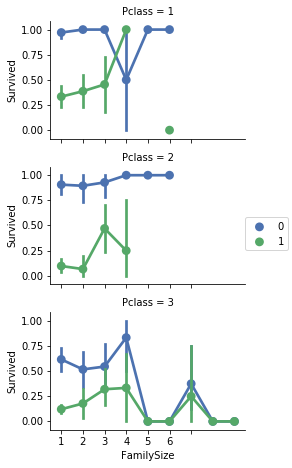

In [1459]:
adult_passengers = train_df.loc[train_df['Age'] >= 2]
grid = sns.FacetGrid(train_df, row='Pclass', size=2.2, aspect=1.6)
grid = grid.map(sns.pointplot, 'FamilySize', 'Survived', 'Sex', palette='deep').set(xticks=[0, 1, 2, 3, 4, 5, 6], xticklabels=[1, 2, 3, 4, 5, 6])
grid.add_legend()

In [1460]:
train_df.info()
print('_'*40)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
Survived      891 non-null int64
Pclass        891 non-null int64
Sex           891 non-null int32
Age           891 non-null int32
Fare          891 non-null int32
Embarked      891 non-null int32
CabinBand     891 non-null int64
Deck          891 non-null int32
Title         891 non-null int64
FamilySize    891 non-null int64
IsAlone       891 non-null int64
dtypes: int32(5), int64(6)
memory usage: 59.2 KB
________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 10 columns):
Pclass        418 non-null int64
Sex           418 non-null int32
Age           418 non-null int32
Fare          418 non-null int32
Embarked      418 non-null int32
CabinBand     418 non-null int64
Deck          418 non-null int32
Title         418 non-null float64
FamilySize    418 non-null int64
IsAlone       418 non-null int64
dtype

In [1461]:
train_df.head(10)

,Survived,Pclass,Sex,Age,Fare,Embarked,CabinBand,Deck,Title,FamilySize,IsAlone
0,0,3,1,2,1,1,1,-1,1,2,0
1,1,1,0,2,2,2,2,3,5,2,0
2,1,3,0,2,1,1,1,-1,4,1,1
3,1,1,0,2,2,1,2,3,5,2,0
4,0,3,1,2,1,1,1,-1,1,1,1
5,0,3,1,-1,1,3,1,-1,1,1,1
6,0,1,1,3,2,1,0,5,1,1,1
7,0,3,1,1,1,1,1,-1,3,5,0
8,1,3,0,2,1,1,1,-1,5,3,0
9,1,2,0,1,1,2,1,-1,5,2,0


## Getting data ready for modeling

In [1463]:
X_train = train_df.drop("Survived", axis=1)
Y_train = train_df["Survived"]
X_test = test_df
X_train.shape, Y_train.shape, X_test.shape

((891, 10), (891,), (418, 10))

## Test different models

In [1464]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(X_train, Y_train)
Y_pred = logreg.predict(X_test)
acc_log = round(logreg.score(X_train, Y_train) * 100, 2)
acc_log

82.49

In [1465]:
coeff_df = pd.DataFrame(train_df.columns.delete(0))
coeff_df.columns =  ['Feature']
coeff_df['Correlation'] = pd.Series(logreg.coef_[0])
coeff_df.sort_values(by='Correlation', ascending=False)

,Feature,Correlation
7,Title,1.006102
1,Sex,0.261939
5,CabinBand,0.231264
6,Deck,0.189364
3,Fare,0.141755
4,Embarked,0.122865
2,Age,-0.128145
8,FamilySize,-0.416435
9,IsAlone,-0.474166
0,Pclass,-0.622522


In [1466]:
from sklearn.svm import SVC, LinearSVC
svc = SVC()
svc.fit(X_train, Y_train)
Y_pred = svc.predict(X_test)
acc_svc = round(svc.score(X_train, Y_train) * 100, 2)
acc_svc

85.07

In [1467]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, Y_train)
Y_pred = knn.predict(X_test)
acc_knn = round(knn.score(X_train, Y_train) * 100, 2)
acc_knn

87.21

In [1468]:
from sklearn.naive_bayes import GaussianNB
gaussian = GaussianNB()
gaussian.fit(X_train, Y_train)
Y_pred = gaussian.predict(X_test)
acc_gaussian = round(gaussian.score(X_train, Y_train) * 100, 2)
acc_gaussian

79.12

In [1469]:
from sklearn.linear_model import Perceptron
perceptron =  Perceptron()
perceptron.fit(X_train, Y_train)
Y_pred = perceptron.predict(X_test)
acc_perceptron = round(perceptron.score(X_train, Y_train) * 100, 2)
acc_perceptron

C:\Anaconda3\envs\deeplearning\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


80.13

In [1470]:
linear_svc = LinearSVC()
linear_svc.fit(X_train, Y_train)
Y_pred = linear_svc.predict(X_test)
acc_linear_svc = round(linear_svc.score(X_train, Y_train) * 100, 2)
acc_linear_svc

82.6

In [1471]:
from sklearn.linear_model import SGDClassifier
sgd = SGDClassifier()
sgd.fit(X_train, Y_train)
Y_pred = sgd.predict(X_test)
acc_sgd = round(sgd.score(X_train, Y_train) * 100, 2)
acc_sgd

C:\Anaconda3\envs\deeplearning\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


75.98

In [1472]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
decision_tree= DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)
Y_pred = decision_tree.predict(X_test)
acc_decision_tree = round(decision_tree.score(X_train, Y_train) * 100, 2)
acc_decision_tree

90.24

## Understand the decision tree

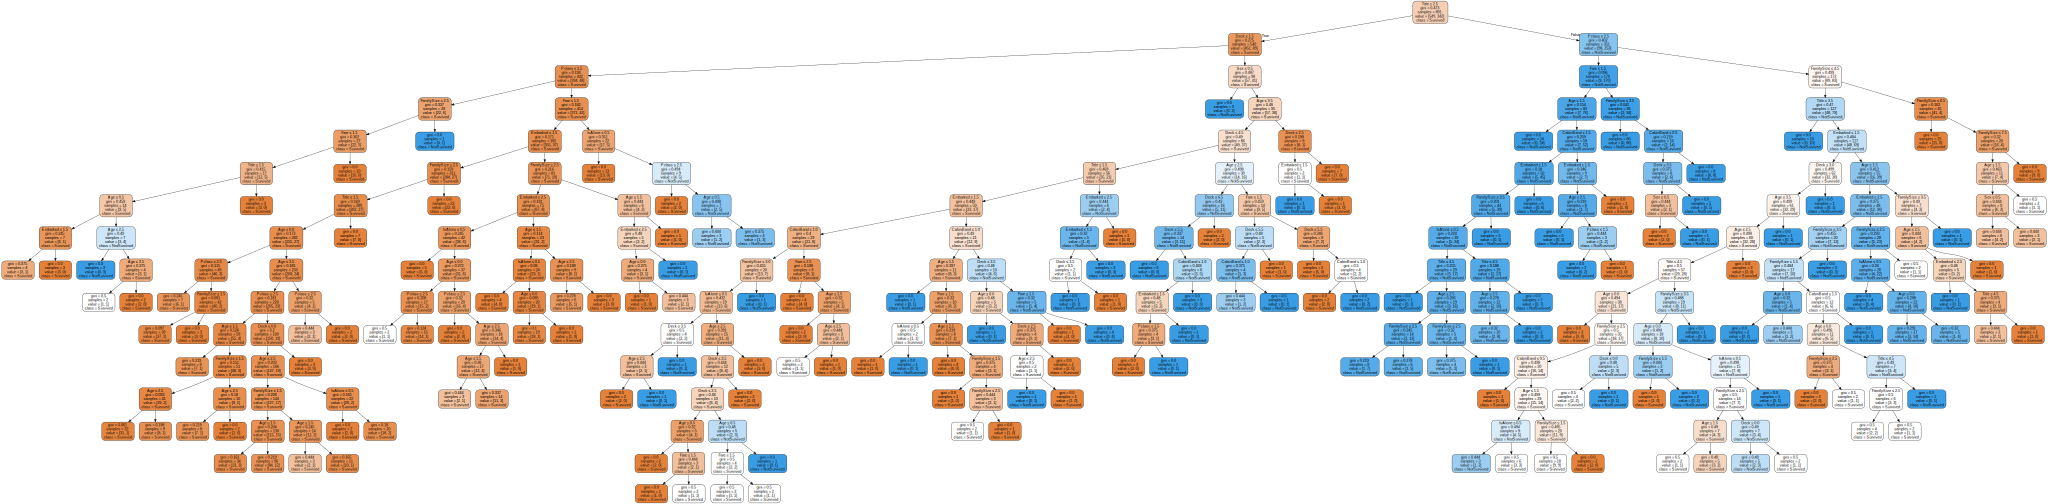

In [1473]:
import graphviz
dot_data = tree.export_graphviz(decision_tree, out_file=None, 
                         feature_names=X_train.columns.values,  
                         class_names=['Survived', 'NotSurvived'],  
                         filled=True, rounded=True,  
                         special_characters=True) 
graph = graphviz.Source(dot_data) 
graph

In [1474]:
from sklearn.ensemble import RandomForestClassifier
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)
Y_pred = random_forest.predict(X_test)
random_forest.score(X_train, Y_train)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
acc_random_forest

90.24

# Random Forest and Decision tree win!